In [101]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Problem

We have dataset with house prices for California. This data has metrics such as the population, median income, median housing price, and so on for each block group (district) in California. 

The district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules. This is costly and time-consuming, and their estimates are not great; in cases where they manage to find out the actual median housing price, they often realize that their estimates were off by more than 20%. This is why the company thinks that it would
be useful to train a model to predict a district’s median housing price given other data about that district. The census data looks like a great dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data.

Machine learning model can solve this problems. The model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

# High-Level Design

- The task we need to solve is **supervised learning**, because we train the model with labeled data. 
- The problem is **regression**, because we need to predict a value. 
- There is no continuous flow of data coming in the system and the data is small enough to fit in memory, so plain **batch learning** should do just fine.

## Performance measure
We can use Root Mean Square Error (RMSE) for our regression problem. It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors. *Mean Absolute Error (MAE) can be used in different situation.*

# Data


In [21]:
data_path = 'data/housing.csv'
housing_data = pd.read_csv(data_path)
housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [6]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AD2106F188>,
      dtype=object)

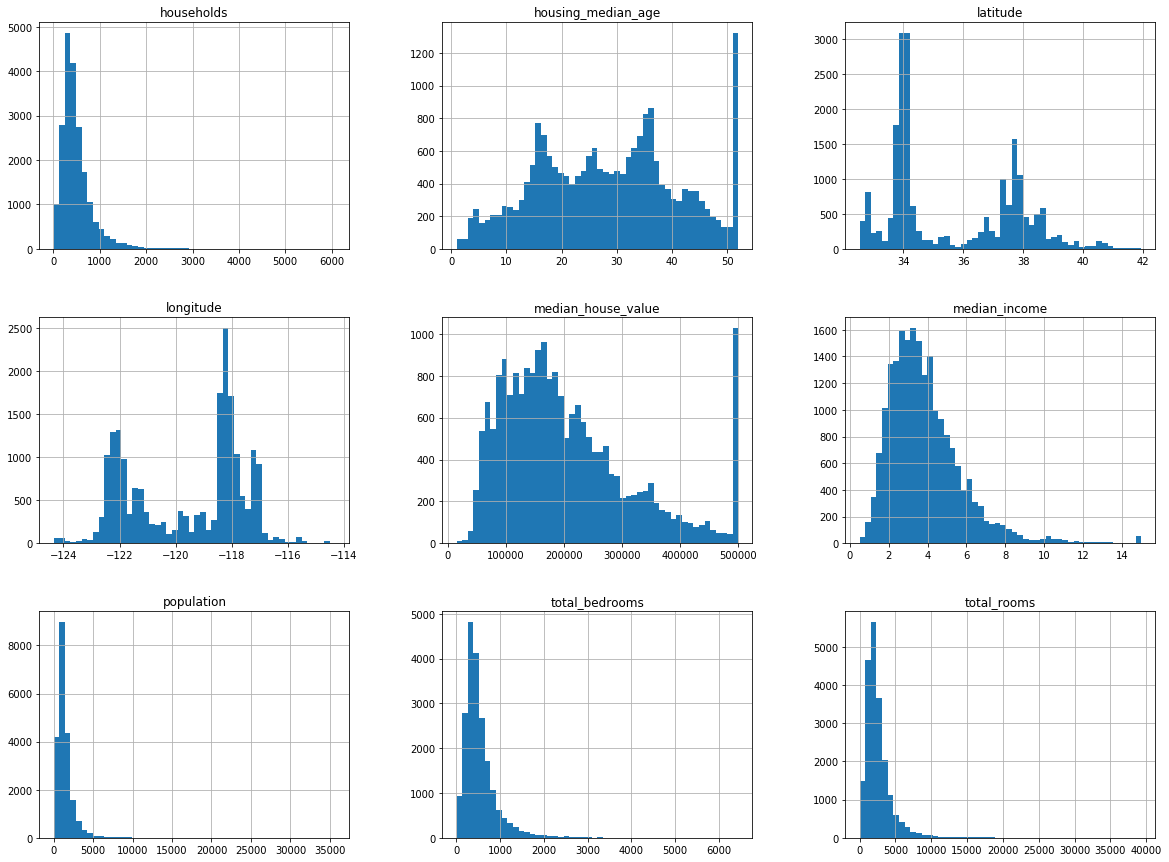

In [20]:
housing_data.hist(bins = 50, figsize=(20,15))

### Observation
The datases is with 20640 entries which is small. Most of the columns are with integer value. The only categorical column is ocean_proximity.

**total_bedrooms** has only 20433 non-null values which means that we have 207 null values.

**ocean_proximity** is categorical feature with values: <1H OCEAN, INLAND, NEAR OCEAN, NEAR BAY, ISLAND

**median_income** is capped and it is not represented with the real value in dollars, but it's scalled. Actually it is scalled 10000. For example the number 3 prepresents $30000.

**housing_median_age** and **median_house_value** are also capped at $500000

# Test set

Separating the data into training and testing set. Testing data will be 20% of the whole data. 

**random_state** is used to generate the same test and train set on each run.

In [55]:
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=43)

## Stratified sampling

The sampling method or the split of the data into training and testing data is random and the ratio between income categories could be with errors. We want to avoid a sampling bias. Median income is an important features, so we have to get a good sample for each income category.

In [59]:
housing_data["income_cat"] = pd.cut(housing_data["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

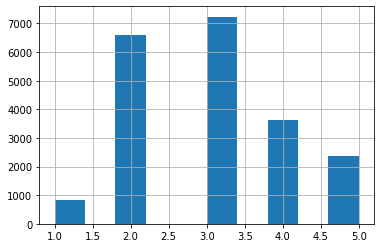

In [60]:
housing_data["income_cat"].hist()

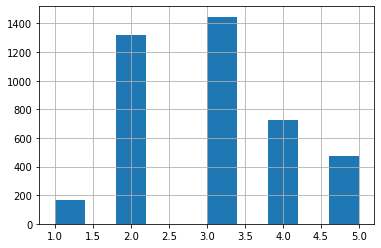

In [62]:
stratified_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 43)
for train_index, test_index in stratified_split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

strat_test_set["income_cat"].hist()

In [69]:
housing_data["income_cat"].value_counts() / len(housing_data)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [70]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [71]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis = 1, inplace = True)

# Data Discovery and Visualization

We need to discover and visualize our data to gain insights from it. We are going to explore only the training set, because we do not want to observe patterns in our test set.

In [74]:
housing_train_data = strat_train_set.copy()

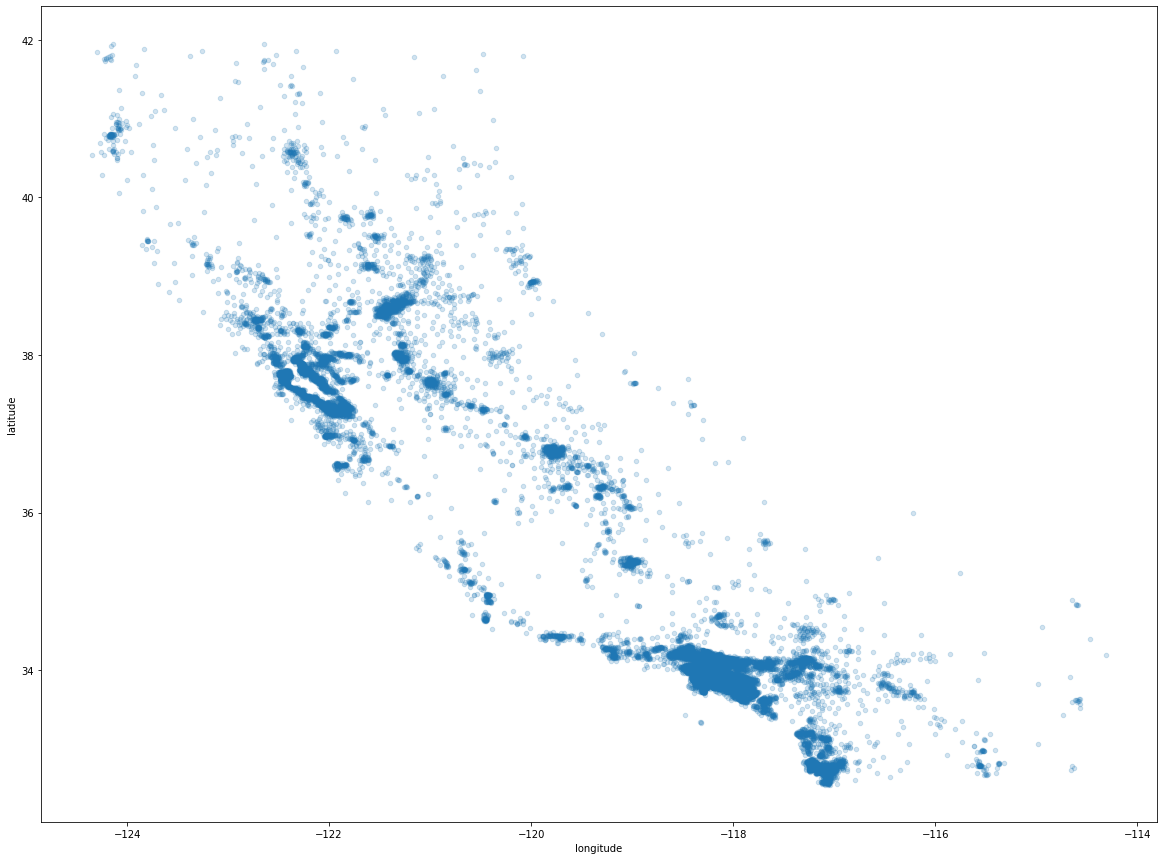

In [80]:
housing_train_data.plot(kind = "scatter", x = "longitude", y = "latitude", figsize=(20, 15), alpha=0.2)

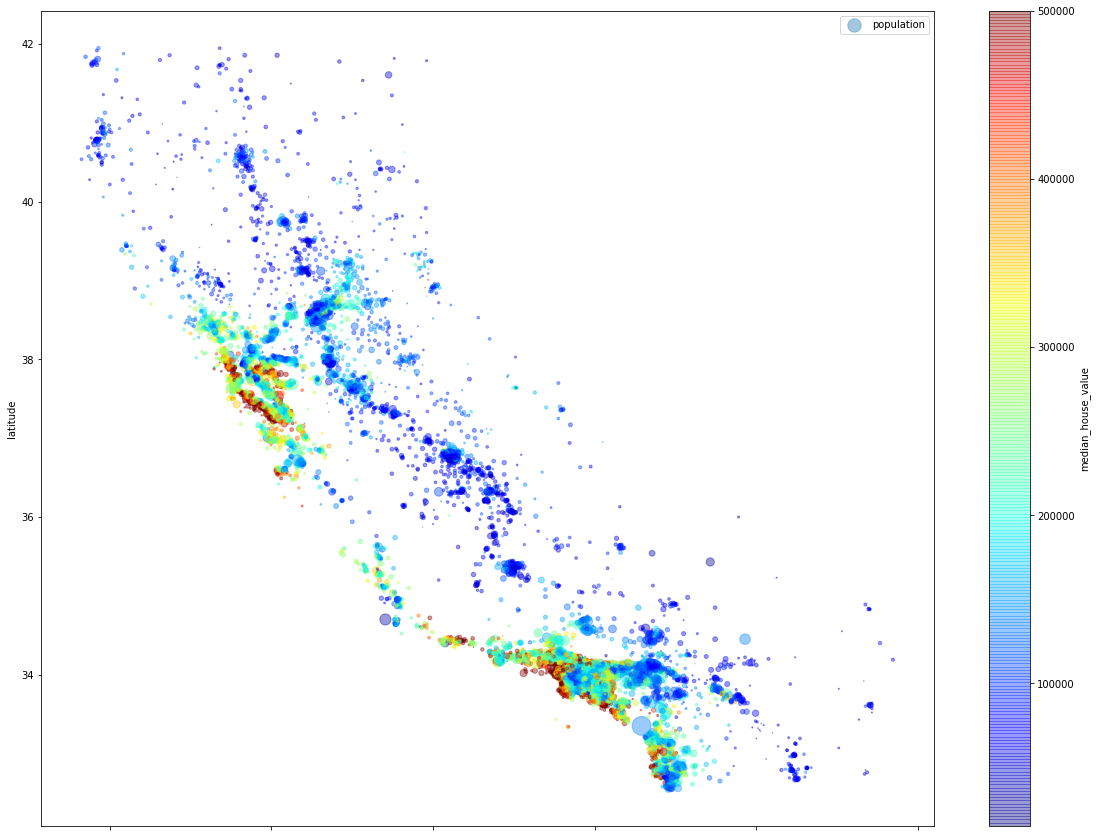

In [94]:
housing_train_data.plot(kind = "scatter", x = "longitude", y = "latitude", figsize = (20, 15), alpha = 0.4, s = housing_train_data["population"]/100, label = "population", c = "median_house_value", cmap=plt.get_cmap("jet"))

In [98]:
correlations = housing_train_data.corr()
correlations

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924855,-0.106959,0.045859,0.071521,0.100295,0.056257,-0.014957,-0.040318
latitude,-0.924855,1.000000,0.010255,-0.035274,-0.067325,-0.109002,-0.071591,-0.079628,-0.148121
housing_median_age,-0.106959,0.010255,1.000000,-0.360635,-0.319675,-0.295576,-0.301763,-0.114523,0.107099
total_rooms,0.045859,-0.035274,-0.360635,1.000000,0.929734,0.853375,0.916392,0.197384,0.135290
total_bedrooms,0.071521,-0.067325,-0.319675,0.929734,1.000000,0.873581,0.978127,-0.008762,0.050002
population,0.100295,-0.109002,-0.295576,0.853375,0.873581,1.000000,0.905745,0.002705,-0.024069
households,0.056257,-0.071591,-0.301763,0.916392,0.978127,0.905745,1.000000,0.011804,0.066341
median_income,-0.014957,-0.079628,-0.114523,0.197384,-0.008762,0.002705,0.011804,1.000000,0.690551
median_house_value,-0.040318,-0.148121,0.107099,0.135290,0.050002,-0.024069,0.066341,0.690551,1.000000


In [100]:
correlations["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690551
total_rooms           0.135290
housing_median_age    0.107099
households            0.066341
total_bedrooms        0.050002
population           -0.024069
longitude            -0.040318
latitude             -0.148121
Name: median_house_value, dtype: float64

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AD2AA01288>,
      dtype=object)

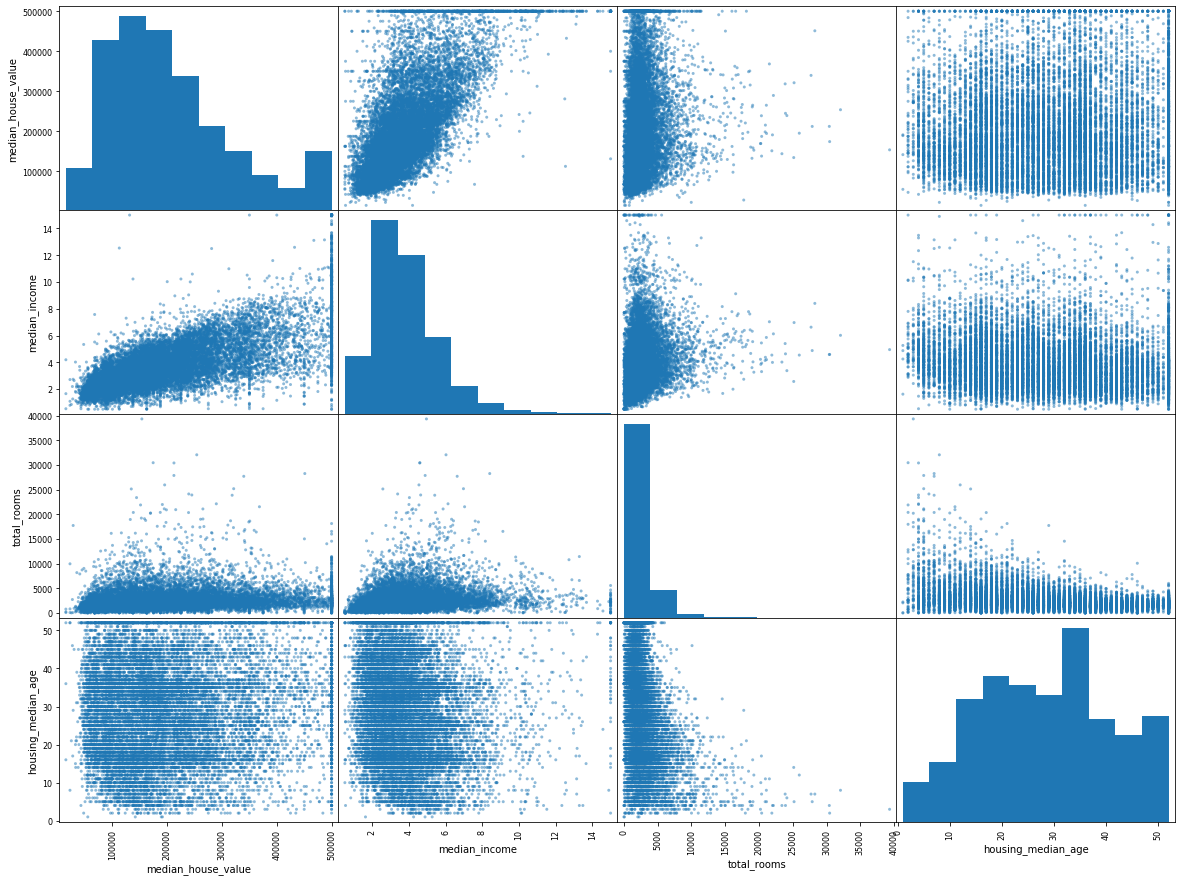

In [104]:
scatter_matrix(housing_train_data[["median_house_value", "median_income", "total_rooms", "housing_median_age"]], figsize = (20, 15))

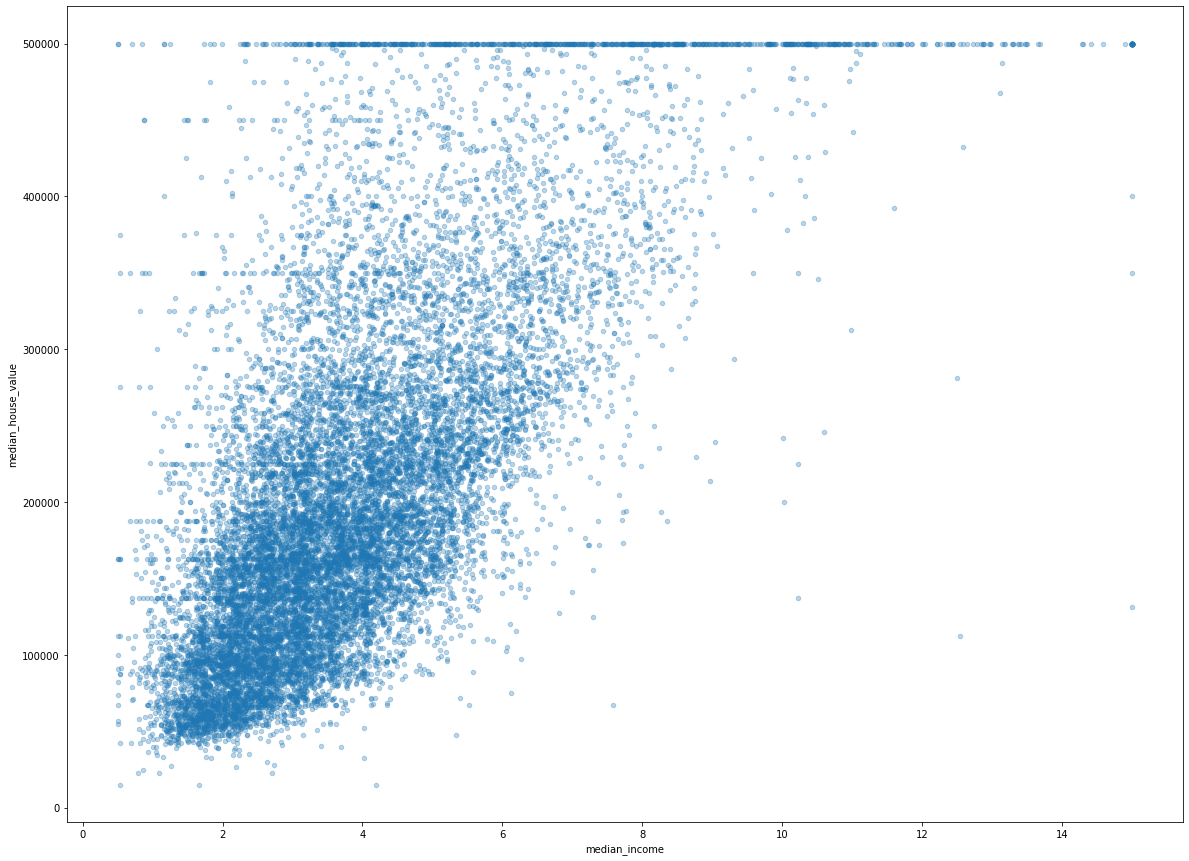

In [116]:
housing_train_data.plot(kind="scatter", x="median_income", y="median_house_value", alpha = 0.3, figsize = (20,15))

## Observation
Several lines can be seen at 500000, 450000, 350000... They can be removed in order to avoid the model to learn to reproduce these data lines.

## Attribute Combinations

In [137]:
housing_train_data["rooms_per_household"] = housing_train_data["total_rooms"]/housing_train_data["households"]
housing_train_data["bedrooms_per_room"] = housing_train_data["total_bedrooms"]/housing_train_data["total_rooms"]
housing_train_data["population_per_household"] = housing_train_data["population"]/housing_train_data["households"]
housing_train_data["bedrooms_per_household"] = housing_train_data["total_bedrooms"]/housing_train_data["households"]

housing_train_data.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690551
rooms_per_household         0.156074
total_rooms                 0.135290
housing_median_age          0.107099
households                  0.066341
total_bedrooms              0.050002
population_per_household   -0.022871
population                 -0.024069
longitude                  -0.040318
bedrooms_per_household     -0.041306
latitude                   -0.148121
bedrooms_per_room          -0.257121
Name: median_house_value, dtype: float64

## Observations
**bedrooms_per_room** gives a good correlation with the median house value. Houses with a lower bedroom/roomration tend to be more expensive.

**rooms_per_household** is more correlated with the median house value than the **total_rooms**.

**population_per_household** has values up to 1243, which is strange number for a household

**rooms_per_household** has values up to 141

# Data Preparation